In [1]:
 %tensorflow_version 1.x
import tensorflow as tf
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from gym.core import Wrapper
from gym.spaces.box import Box
import cv2


TensorFlow 1.x selected.


In [2]:
!pip install gym-super-mario-bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT


     |████████████████████████████████| 204kB 7.9MB/s 
     |████████████████████████████████| 81kB 5.0MB/s 
     |████████████████████████████████| 1.1MB 14.7MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.4-cp36-cp36m-linux_x86_64.whl size=440298 sha256=71dc2cec0d272af164957d1e1d5f721388e50dc3befea4735048077c342a821d
  Stored in directory: /root/.cache/pip/wheels/17/e2/42/5e197e5b9b3d847c6fe2cb1ffbea2afff891f8d1afa600aeed
Successfully built nes-py
ERROR: gym 0.17.2 has requirement pyglet<=1.5.0,>=1.4.0, but you'll have pyglet 1.5.7 which is incompatible.
  Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0


In [7]:
!wget -q https://raw.githubusercontent.com/ironman-0-0-7/RL_supermario/master/atari_util.py

In [8]:
from atari_util import PreprocessAtari
def make_env():
    env =  gym_super_mario_bros.make('SuperMarioBros-v0')
    env=JoypadSpace(env, SIMPLE_MOVEMENT)
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4)
    return env



env = make_env()
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 7
Action names: ['NOOP']


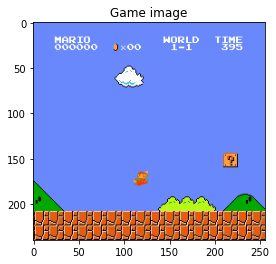

In [10]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()


In [11]:

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [12]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Input

Using TensorFlow backend.


In [13]:
class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            
            input=Input(shape=state_shape)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(input)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x=Flatten()(x)
            x=Dense(128, activation='relu')(x)

            state_value=Dense(1,activation='relu')(x)
            logits=Dense(n_actions,activation='relu')(x)

            self.network=Model(inputs=input,outputs=[state_value,logits])

            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        state_v,logit=self.network(state_t)
        logits = logit
        state_values =state_v[:,0]
        
        return logits, state_values
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [14]:
 agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[0.15241371 0.         0.         0.         0.12566504 0.01910554
  0.02883477]]
state values:
 [0.]


In [17]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [18]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

State shape: (10, 42, 42, 4)
Actions: [1 2 4 4 5 5 4 4 6 0]
Rewards: [0 0 0 0 0 0 0 0 0 0]
Done: [False False False False False False False False False False]


In [19]:
#  placeholders 
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [20]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)

# There is no next state if the episode is done!
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits, axis=-1)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits, axis=-1)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

In [21]:
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values
entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")
target_state_values = rewards_ph+gamma*next_state_values


actor_loss = -tf.reduce_mean(logp_actions * tf.stop_gradient(advantage), axis=0) - 0.001 * tf.reduce_mean(entropy, axis=0)
critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2, axis=0)

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
import pandas as pd

def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

  5%|▌         | 5446/100000 [02:43<47:15, 33.34it/s]


KeyboardInterrupt: ignored

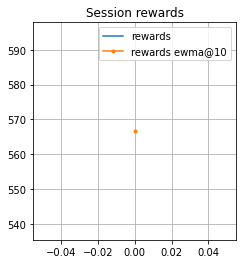

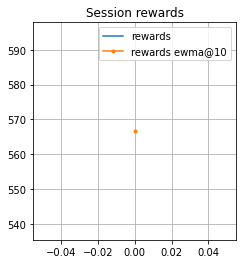

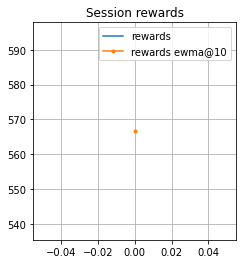

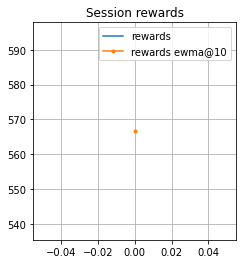

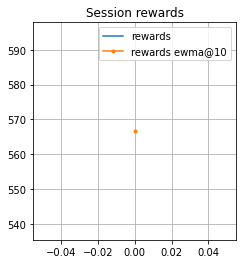

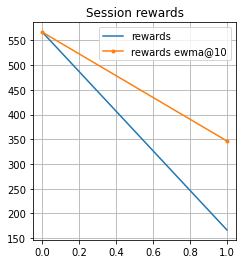

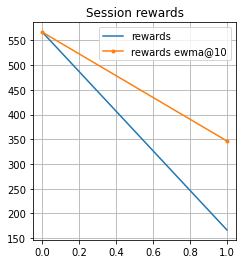

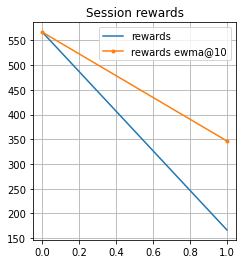

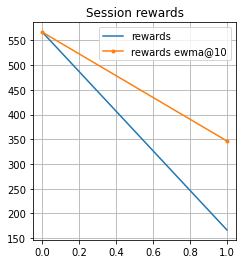

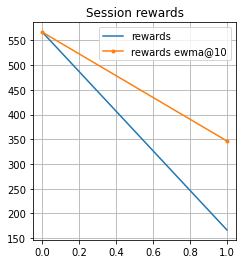

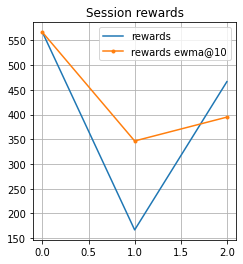

In [36]:
import tqdm
from IPython.display import clear_output

with tqdm.trange(len(entropy_history), 100000) as t:
    for i in t:
        agent_outputs = agent.step(batch_states)
        batch_actions = agent.sample_actions(agent_outputs)
        batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

       
        batch_rewards = batch_rewards * 0.01

        feed_dict = {
            states_ph: batch_states,
            actions_ph: batch_actions,
            next_states_ph: batch_next_states,
            rewards_ph: batch_rewards,
            is_done_ph: batch_done,
        }

        _, ent_t = sess.run([train_step, entropy], feed_dict)
        entropy_history.append(np.mean(ent_t))

        batch_states = batch_next_states

        if i % 500 == 0:
            if i % 2500 == 0:
                rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))

            clear_output(True)

            plt.figure(figsize=[8, 4])
            plt.subplot(1, 2, 1)
            plt.plot(rewards_history, label='rewards')
            plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
            plt.title("Session rewards")
            plt.grid()
            plt.legend()

           

In [24]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [25]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=3)

print("Final mean reward:", np.mean(final_rewards))
from pathlib import Path
video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

Exception ignored in: <bound method Monitor.__del__ of <Monitor<PreprocessAtari<JoypadSpace<TimeLimit<SuperMarioBrosEnv<SuperMarioBros-v0>>>>>>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/gym/wrappers/monitor.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/gym/wrappers/monitor.py", line 131, in close
    super(Monitor, self).close()
  File "/usr/local/lib/python3.6/dist-packages/gym/core.py", line 236, in close
    return self.env.close()
  File "/usr/local/lib/python3.6/dist-packages/gym/core.py", line 236, in close
    return self.env.close()
  File "/usr/local/lib/python3.6/dist-packages/gym/core.py", line 236, in close
    return self.env.close()
  [Previous line repeated 1 more time]
  File "/usr/local/lib/python3.6/dist-packages/nes_py/nes_env.py", line 339, in close
    raise ValueError('env has already been closed.')
ValueError: env has already been closed.


Final mean reward: 711.3333333333334


In [27]:
from google.colab import files
files.download(video_names[-2]) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>